# Forecasting the Number of Domestic Flights to Hawaii

The dataset I'm going to use was gathered from the [US Bureau of Transportation Statistics](https://transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) and has information on flights within the US. The file I gathered contains information on flights to Hawaii from Jan/2014 to March/2018. Since Hawaii is a holiday destination, I expect it to be very seasonal and predictable and, therefore, perfect for traditional forecasting models.

On this notebook, I'll be using the following models:

- [Facebook's Prophet](https://facebook.github.io/prophet/)

- [Exponential Smoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing)

## 1 - Loading and Analyzing the Data

I've compiled monthly data from the US Bureau of Transportation Statistics into a single file named 'hawaii_data.csv'. This file has one row per flight.

First, I'll load it and then build a dataframe 'daily_data', with data grouped by day.

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import lag_plot
from datetime import datetime
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

%matplotlib inline

data = pd.read_csv('hawaii_data.csv')

daily_data = data.groupby('FL_DATE').YEAR.count().reset_index()
daily_data.columns = ['ds', 'y']

Now, I'll plot the data in order to check for seasonality

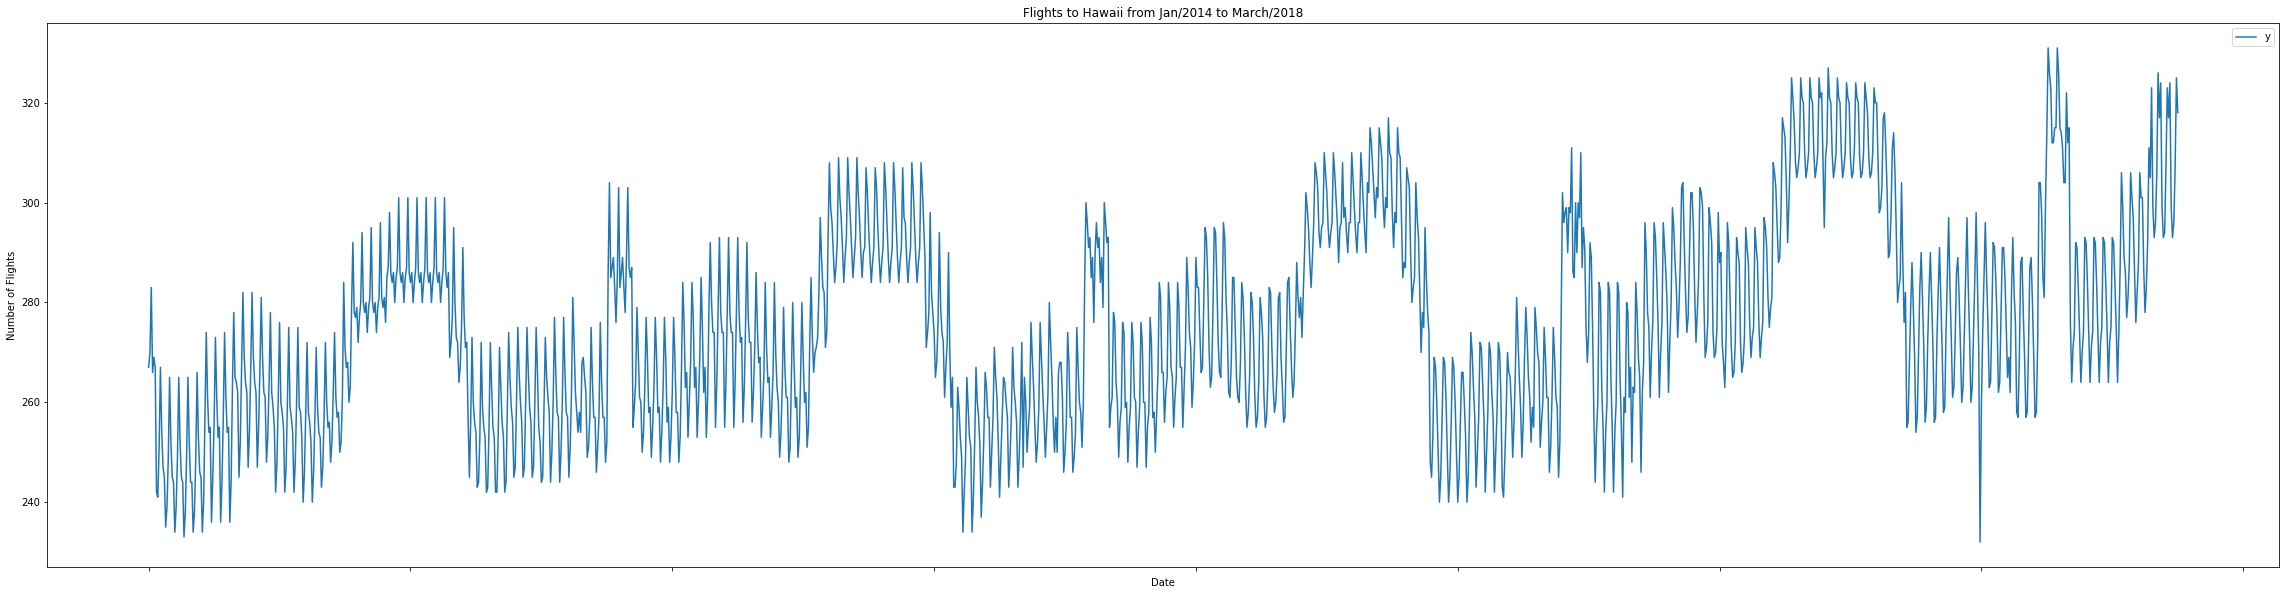

In [10]:
daily_data.plot(x='ds', y='y', figsize=(40,10))
plt.title('Flights to Hawaii from Jan/2014 to March/2018')
plt.ylabel('Number of Flights')
plt.xlabel('Date')
plt.show()

The plot seems to be very seasonal, with its yearly and weekly seasonality very strong. I will single them out in the following cell.

### Yearly Trend

As is clear from the plots bellow, the number of flights to Hawaii varies almost exactly the same way year after year. It increases during the American summer (May ~ August) and then again at the end of the year (mid-December onward). There's also a small up-trend from February to April that is likely related to Spring-Break.

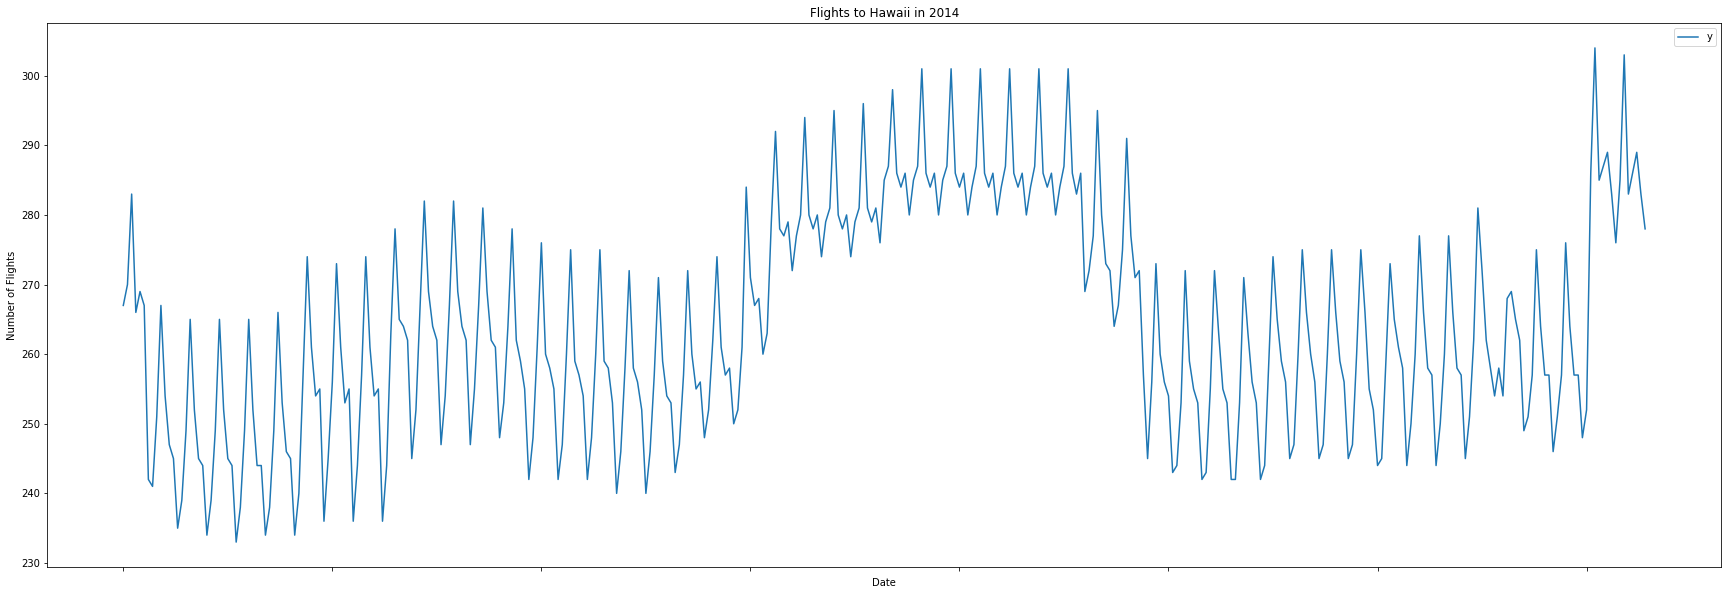

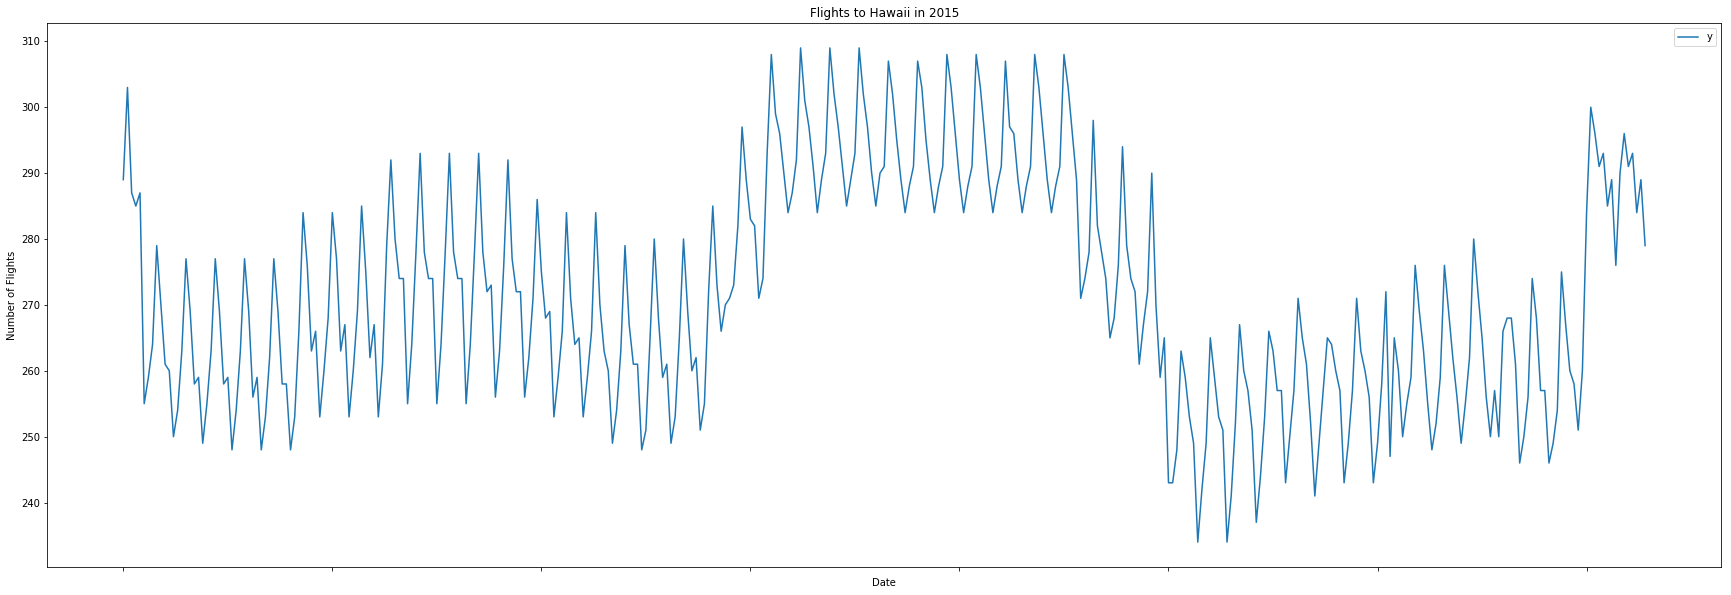

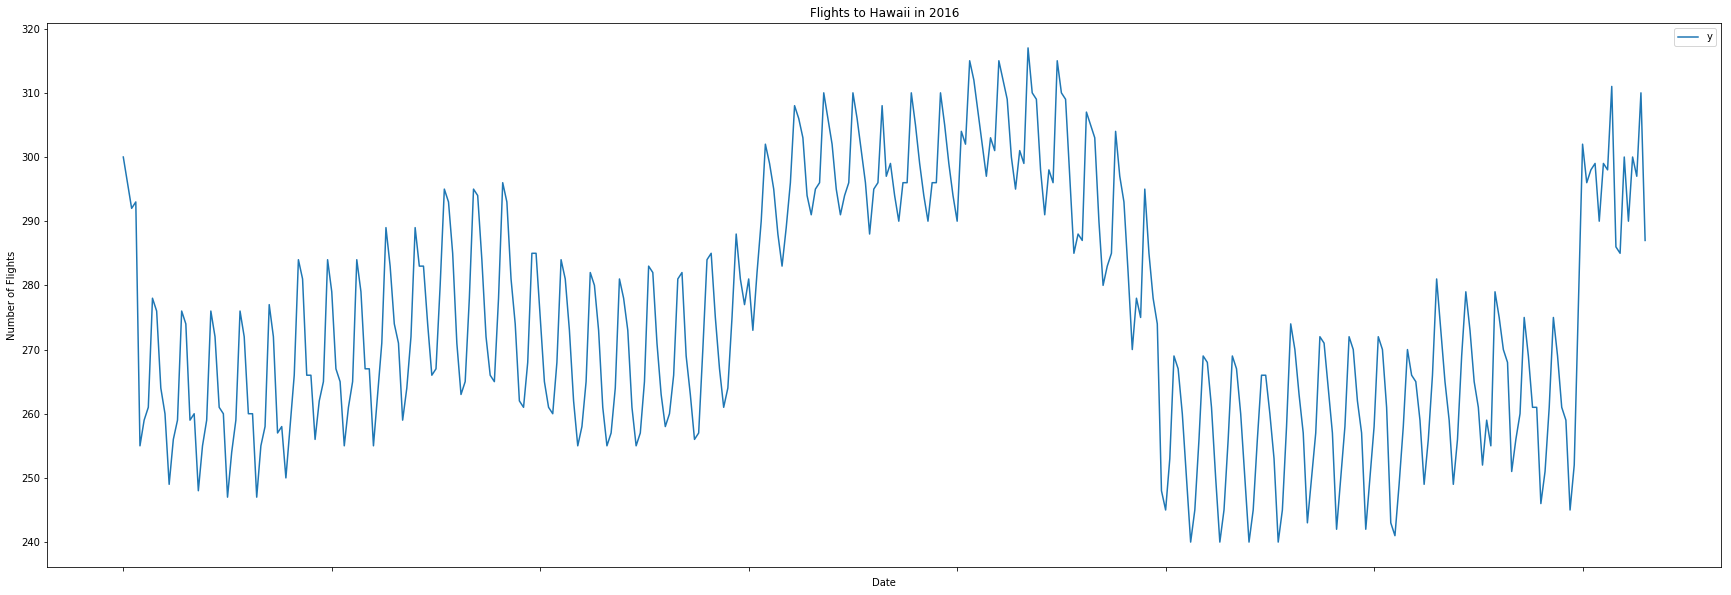

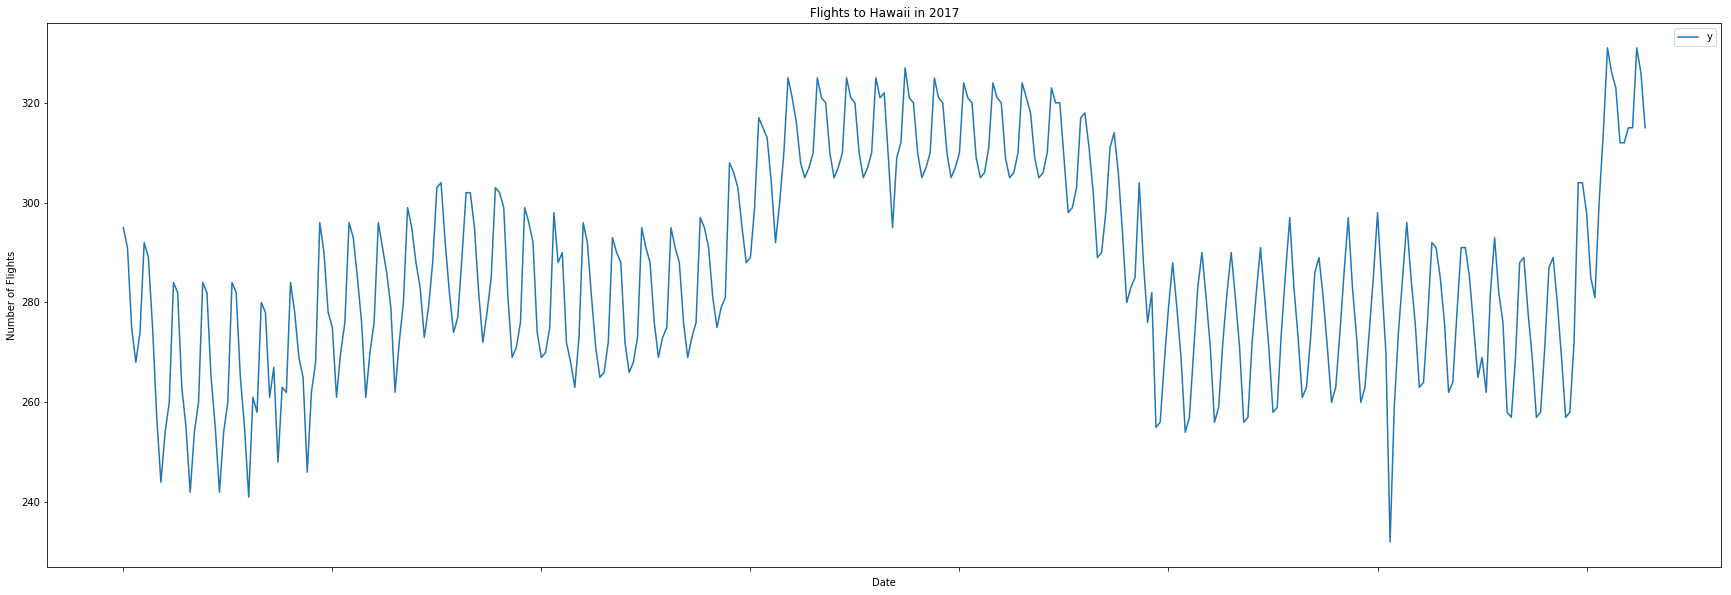

In [11]:
for year in [2014, 2015, 2016, 2017]:
    daily_data[(daily_data.ds>=str(year)+'-01-01')&(daily_data.ds<=str(year)+'-12-31')].plot(x='ds', y='y', figsize=(30,10))
    plt.title('Flights to Hawaii in ' + str(year))
    plt.ylabel('Number of Flights')
    plt.xlabel('Date')
    plt.show()

### Weekly Trend

From the plot bellow, it's clear that the number of flights peaks on the weekend and dips on Tuesday ~ Wednesday.

Aside from the plot bellow, I also plotted a scatter plot with red representing weekends (Fri~Sat) , green representing Tues~Wed and blue representing the rest. The pattern hold of the 4 years worth of data.


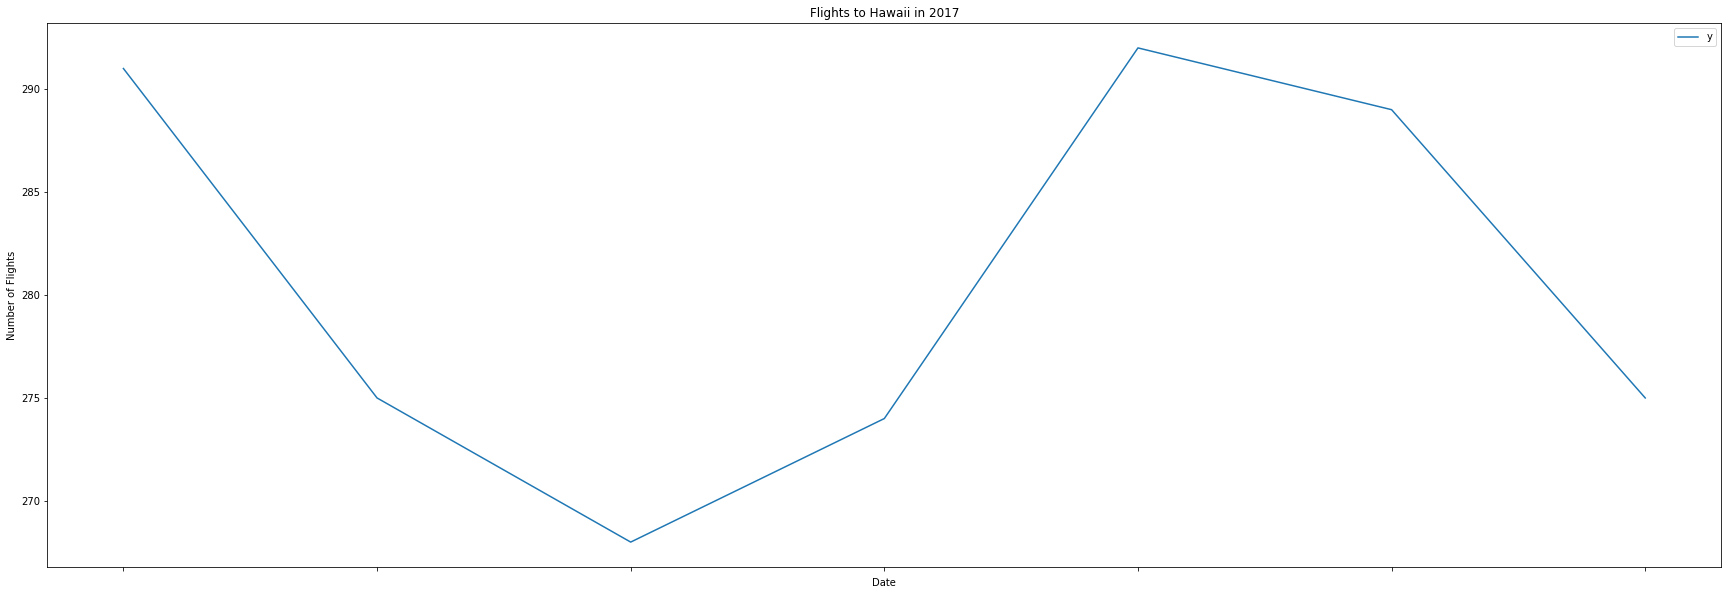

In [12]:
daily_data[(daily_data.ds>=str(year)+'-01-02')&(daily_data.ds<=str(year)+'-01-08')].plot(x='ds', y='y', figsize=(30,10))
plt.title('Flights to Hawaii in ' + str(year))
plt.ylabel('Number of Flights')
plt.xlabel('Date')
plt.show()

In [13]:
daily_data['weekday'] = daily_data.ds.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())

In [14]:
def get_color(row):
    if (row['weekday'] == 2 ) or ( row['weekday'] == 1):
        return 'g'
    elif (row['weekday'] == 4) or (row['weekday'] == 5):
        return 'r'
    else:
        return 'b'

In [15]:
daily_data['color'] = daily_data.apply(get_color, axis=1)

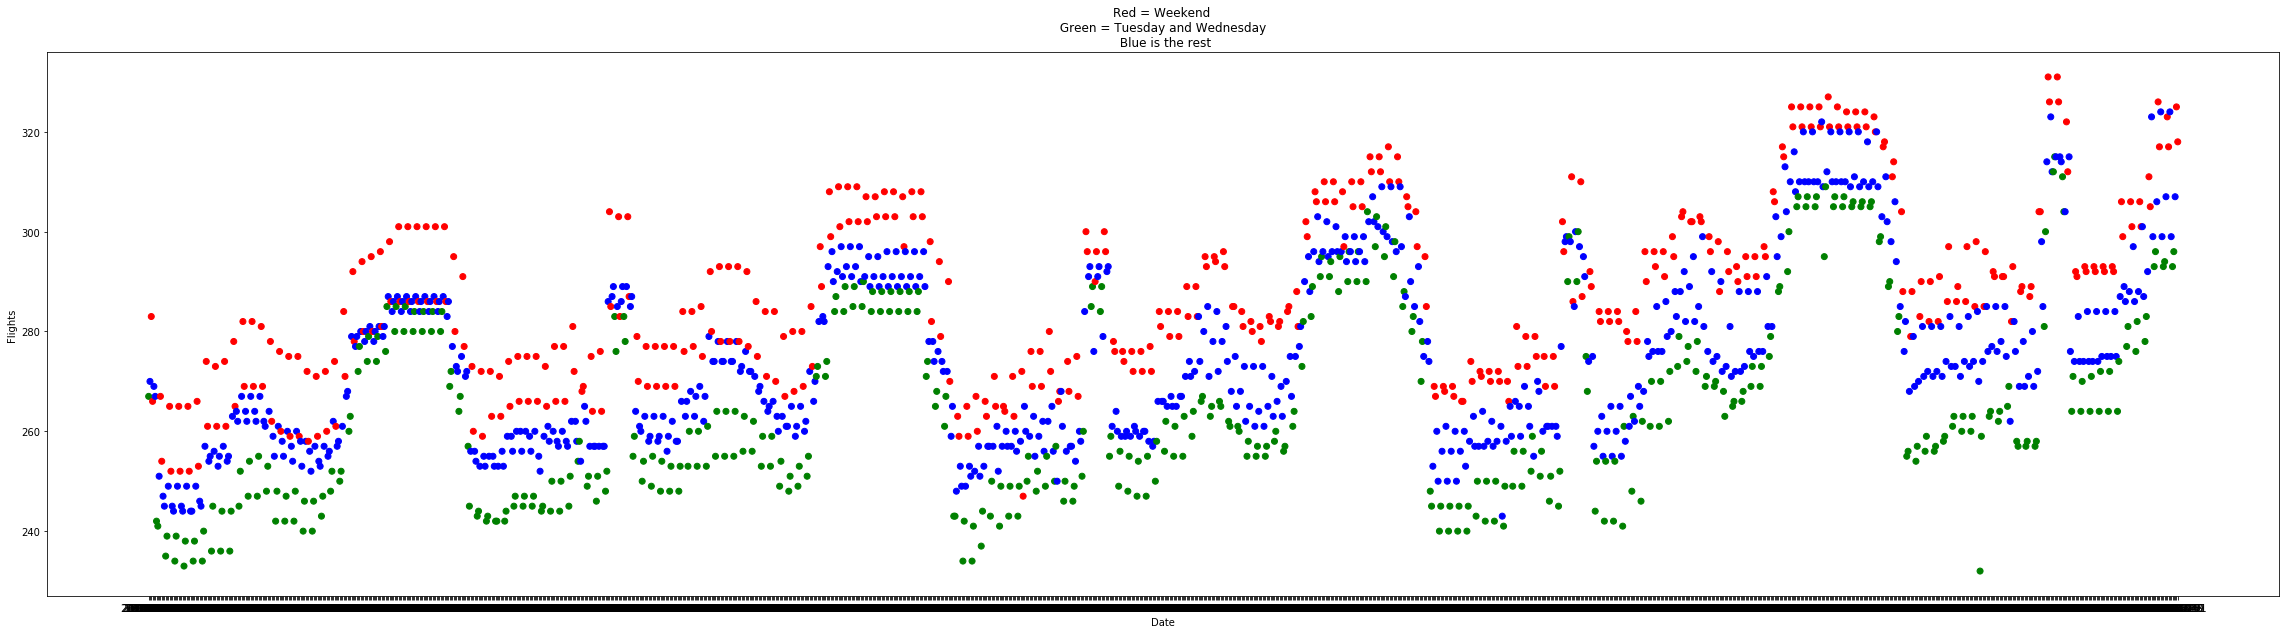

In [16]:
fig = plt.figure(figsize=(40,10))
plt.scatter(x=daily_data['ds'].values, y=daily_data['y'].values, color=daily_data['color'].values)
plt.title('Red = Weekend \n Green = Tuesday and Wednesday \n Blue is the rest')
plt.xlabel('Date')
plt.ylabel('Flights')
plt.show()

### Auto-Correlation & Stationarity

As most of the models I'm about to try are auto-regressors (AR), it's wise to check for auto-correlation so not only I can find if it's worth it to try AR models, but which parameters should be chosen.

Auto-Correlation is nothing but a correlation between a vector [x0, x1, x2, x3, x4, ...] and a lagged version of the same vector [x1, x2, x3, x4, x5, ...] (lag=1) or [x2, x4, x5, x6, x7, ...] (lag=2). Intuitively, a strong lag 1 correlation, for example, means that a value y(t+1) can be guessed from y(t). That would not be true for random noise, for example.

Right bellow, there's a Lag plot (plot of y(t+1) vs y(t) ), which is a visual tool for us to understand visually the meaning of a lag 1 correlation.

I will also check for stationarity, which is the characteristic of trendless time series data. For example, a rising stock is not trendless, therefore, not stationary. This feature is important because many models assume stationary time series and, if that condition is not met, we must find a way to convert this trendy dataset to a stationary one.

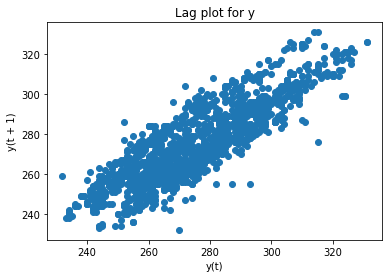

Correlation: 


0.86504472281730982

In [17]:
lag_plot(daily_data.y)
plt.title('Lag plot for y')
plt.show()

dataframe = pd.concat([daily_data.y.shift(1), daily_data.y], axis=1)
dataframe.columns = ['t-1', 't']

print('Correlation: ')
dataframe.corr().loc['t-1', 't']

So, for a lag of 1, there's a .86 correlation, which is pretty high. In order to avoid the hussle of repeating this step for every possible lag, we can use the function ACF (Auto-Correlation Function) from the library statsmodels. 

Each point link a lag value to a correlation. The light blue band around the plot shows the confidence level of that lag value.

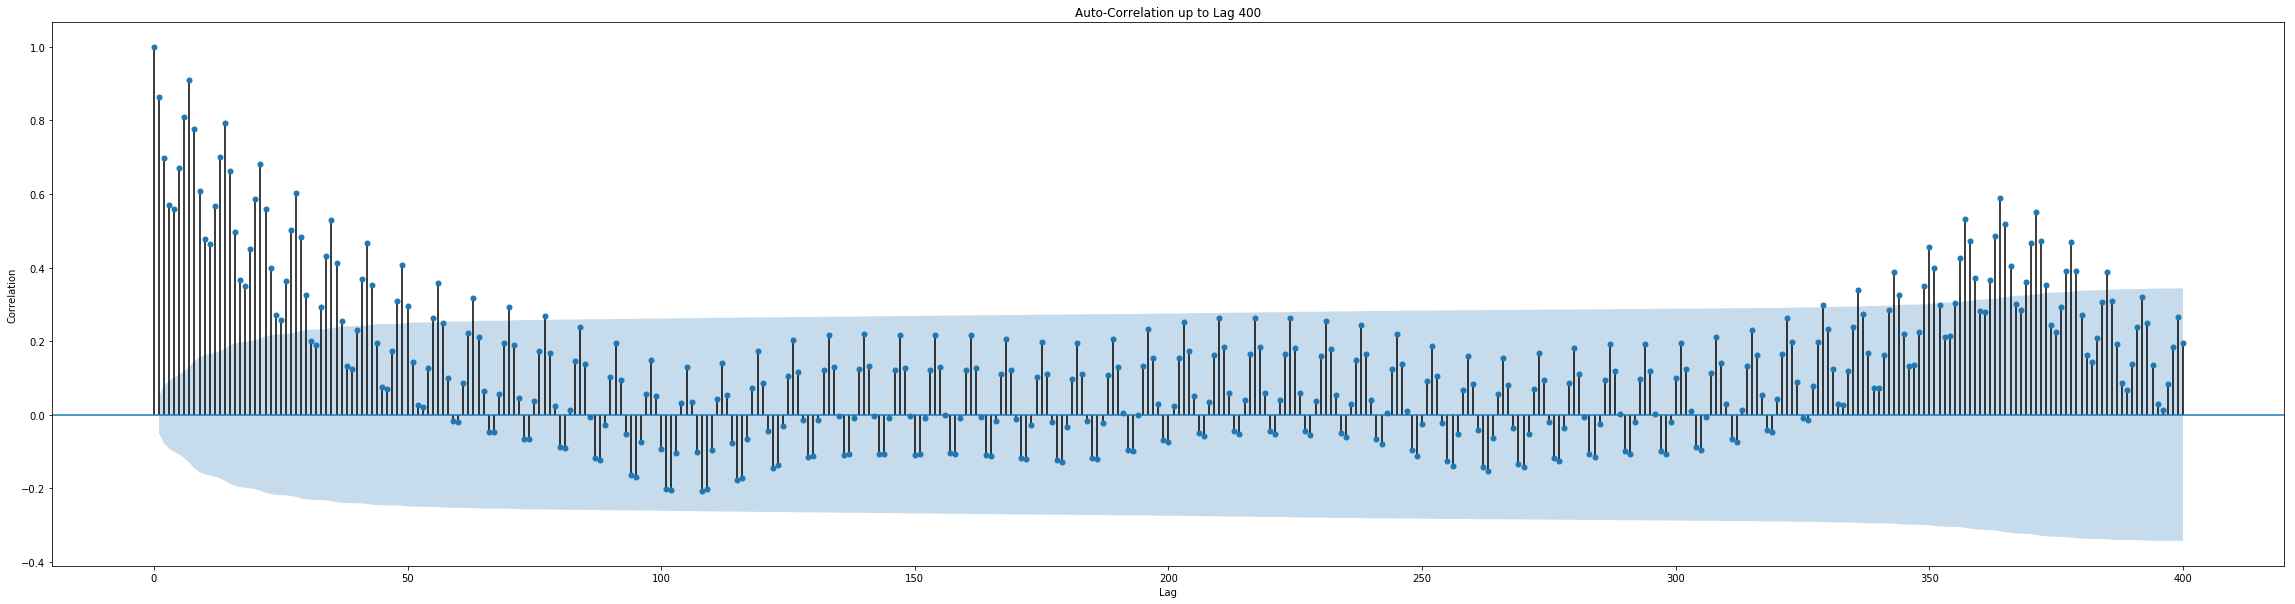

In [18]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(40,10))
    plot_acf(daily_data.y, lags=400)
    plt.title('Auto-Correlation up to Lag 400')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()

From the wave-like shape of the plot, it's clear that:
- There's a really strong 7 day auto-correlation, which basically means that the value for a given Wednesday is pretty similar to the previous Wednesday
- There's a really strong 1 year auto-correlation, which means that the value for 2017/01/01 is similar to 2016/01/01

Another useful plot is the Partial Auto-Correlation Function (PACF):

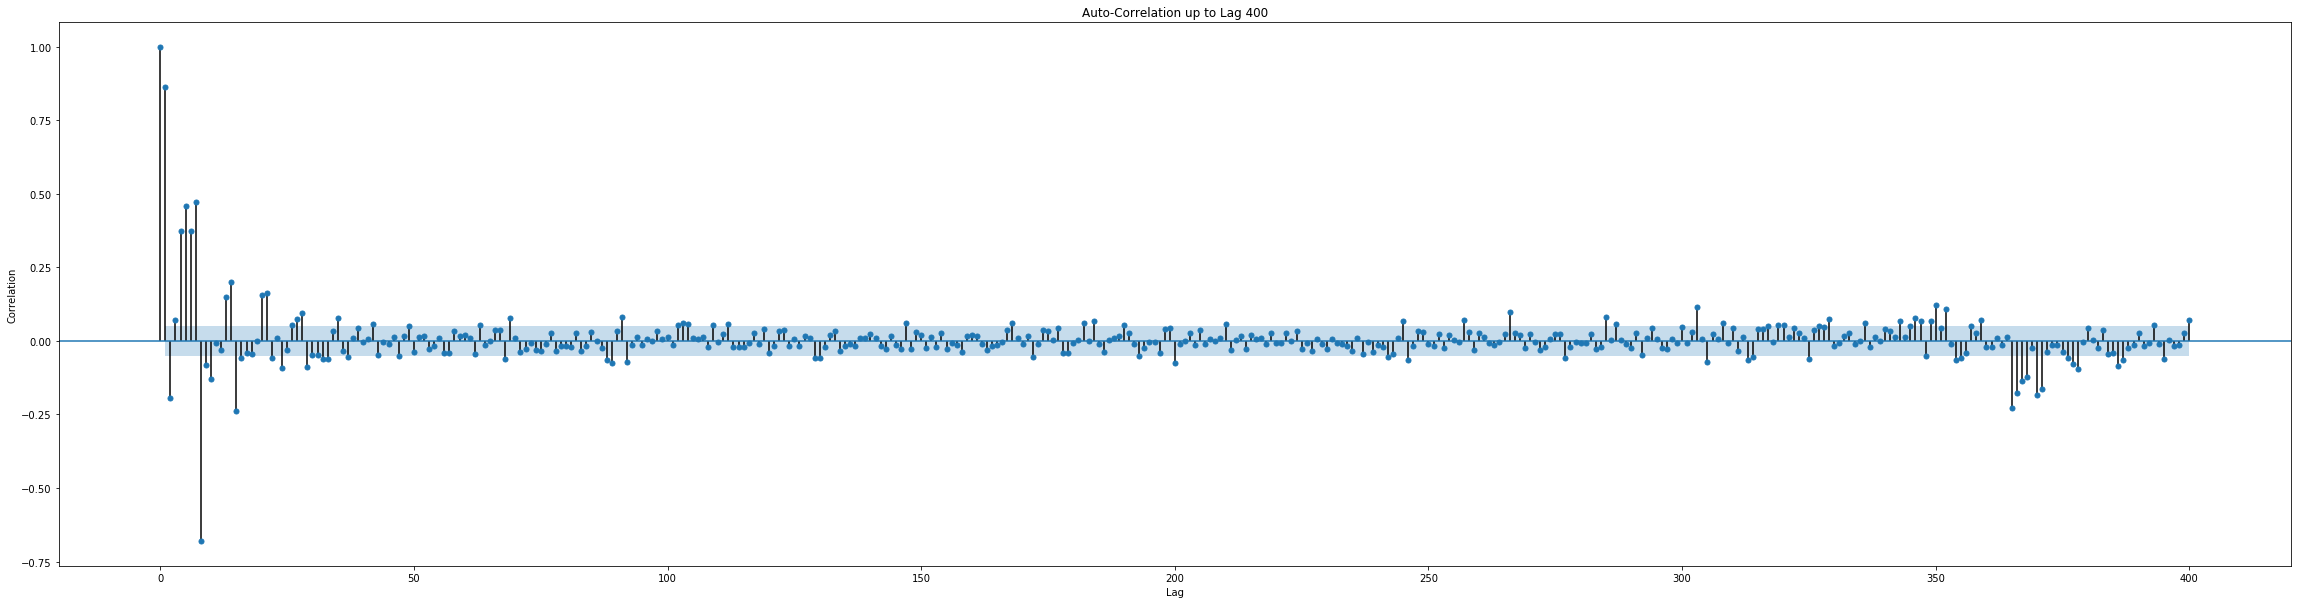

In [78]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(40,10))
    plot_pacf(daily_data.y, lags=400)
    plt.title('Auto-Correlation up to Lag 400')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()

Although the seasonal effect on the data is very strong, there seems to be a upward moving trend as well. Therefore, the data is not completely stationary.

We can check for this trend using statsmodels' seasonal_decompose function.

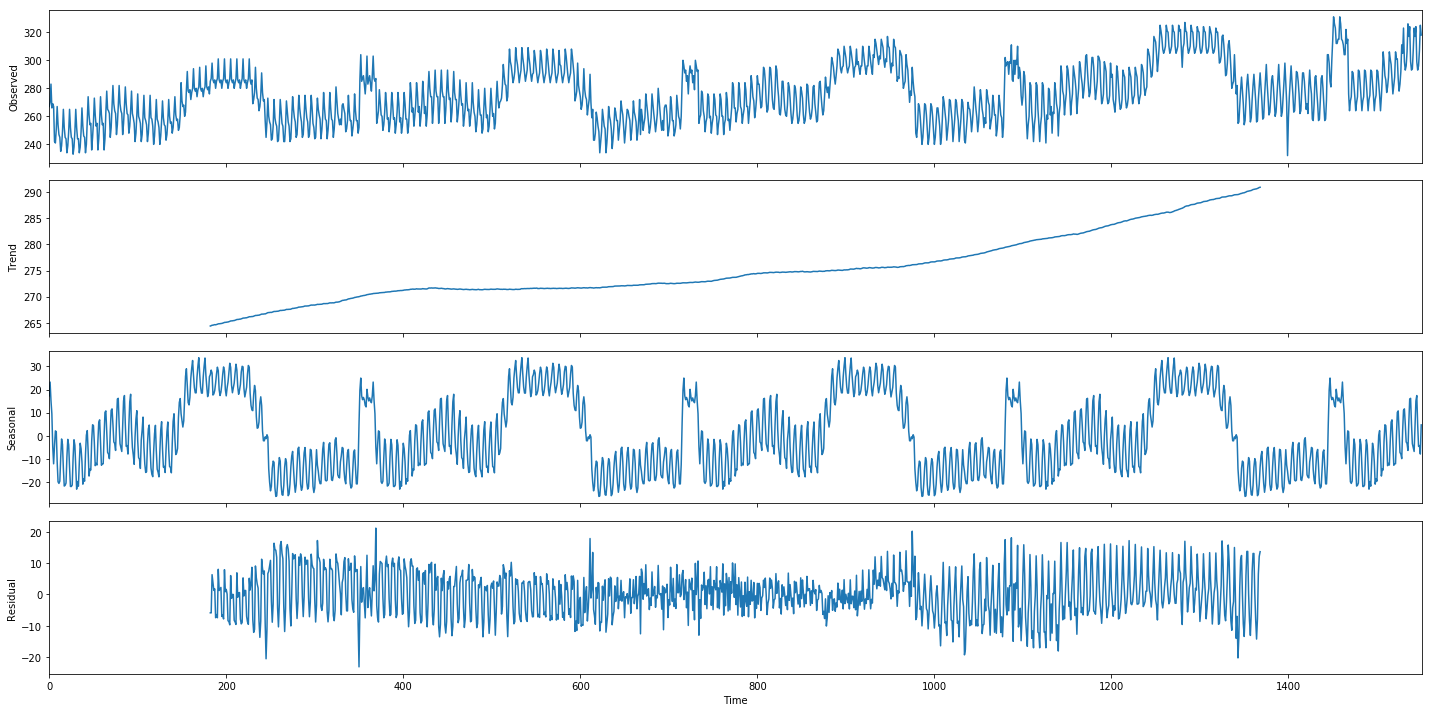

In [20]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(20,10))
    result = seasonal_decompose(daily_data.y.values, model='additive', freq=365)
    result.plot()
    plt.show()


#### So far...

We've found the following:
- __Non-Stationary__: There seems to be a upward tred one the data, which can be easily seem on the plot above
- __Seasonal__: Yearly and weekly seasonalities are very strong
- __Peak Spots__: There seems to be peaks in trips during weekends (week seasonality) and during both summer and winter (yearly seasonality), with summer being the one that lasts longer

The auto-correlation and partial-correlation plots will be specially useful when modeling the data with AR, MA, ARMA, ARIMA or SARIMA models.

## Modelling

Now that we've got a sense of what the data looks like and how it behaves, we can start the modeling part. From the previous study, we can find all that we need in order to fit a good forecasting model using 2014~2017 data on the model and test it for 2018 data. Therefore, finding a raw test error that will quantify the quality of our model.

In [27]:
train = daily_data[daily_data.ds<'2018-01-01'][['ds', 'y']]
train.ds = pd.to_datetime(train.ds)

test = daily_data[daily_data.ds>='2018-01-01'][['ds', 'y']]
test.ds = pd.to_datetime(test.ds)

### 1) Facebook's Prophet

Facebook published on this [paper](https://peerj.com/preprints/3190/) the underlying logic behind its Prophet model. It basically strips the data into 3 main componentes: 

*y(t) = g(t) + s(t) + h(t)*

g: trend factor, 

s: seasonal factor 

h:holiday factor

The package is very easy to use and reportedly outputs a very reasonable forecast. I will be using it to forecast the first 3 months of 2018 using data from 2014 ~ 2017.

In [102]:
prophet = Prophet(daily_seasonality=False)
prophet.fit(train)
future = prophet.make_future_dataframe(periods=90)
forecast = prophet.predict(future)
forecast_2018 = forecast[forecast.ds>='2018-01-01']

/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale


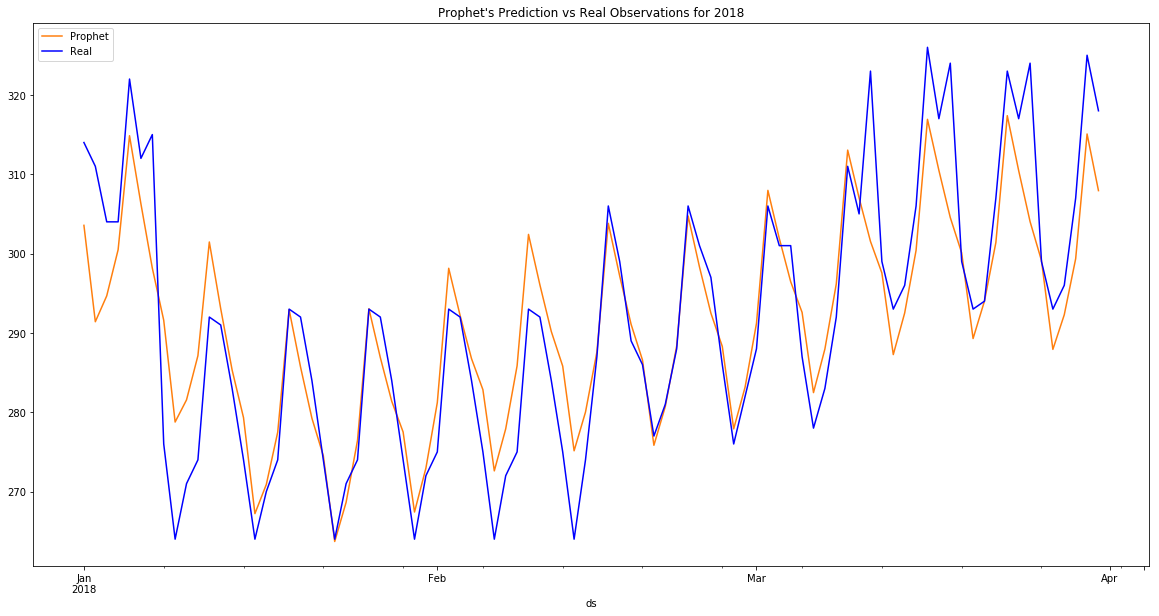

Mean Absolute Error: 5.43991747183
Root Mean Square Error : 7.318534369735713


In [103]:
fig, ax = plt.subplots(figsize=(20,10))
forecast_2018.plot(x='ds', y='yhat', ax=ax, label='Prophet', color='C1')
test.plot(x='ds', y='y', ax=ax, label='Real', color='b')
plt.legend()
plt.title("Prophet's Prediction vs Real Observations for 2018")
plt.show()
print('Mean Absolute Error: ' + str(mean_absolute_error(y_true=test.y, y_pred=forecast_2018.yhat)))
print('Root Mean Square Error : ' + str(sqrt(mean_squared_error(y_true=test.y, y_pred=forecast_2018.yhat))))

The forecast from Prophet is pretty good, even without any tweakings from the standard model. We can also plot the trend and yearly/weekly seasonalities. 

/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()


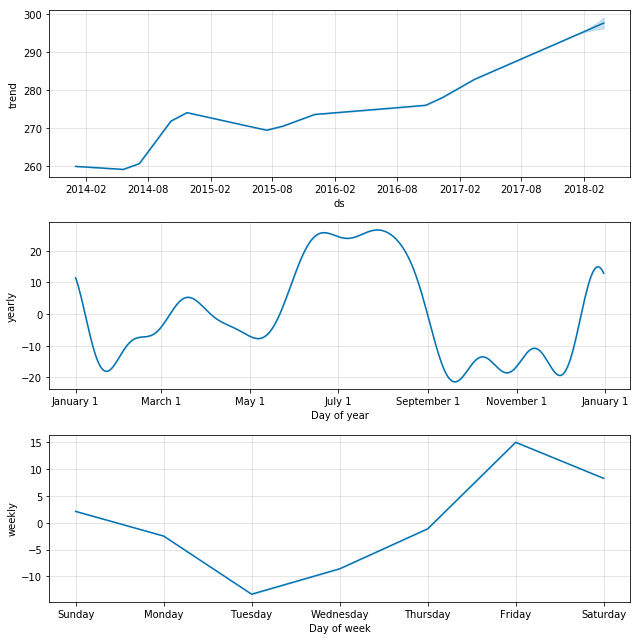

In [104]:
prophet.plot_components(forecast)
plt.show()

As we can see from the plots above, the model pretty much picked up on the weekly/yearly seasonalities and the trend.

If we plot the forecast for the whole year 2018, we will see that it's a very good guess, given the previous years.

In [109]:
prophet = Prophet(daily_seasonality=False)
prophet.fit(train)
future = prophet.make_future_dataframe(periods=365)
forecast = prophet.predict(future)
forecast_2018 = forecast[forecast.ds>='2018-01-01']

/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale


In [113]:
daily_data.ds = pd.to_datetime(daily_data.ds)

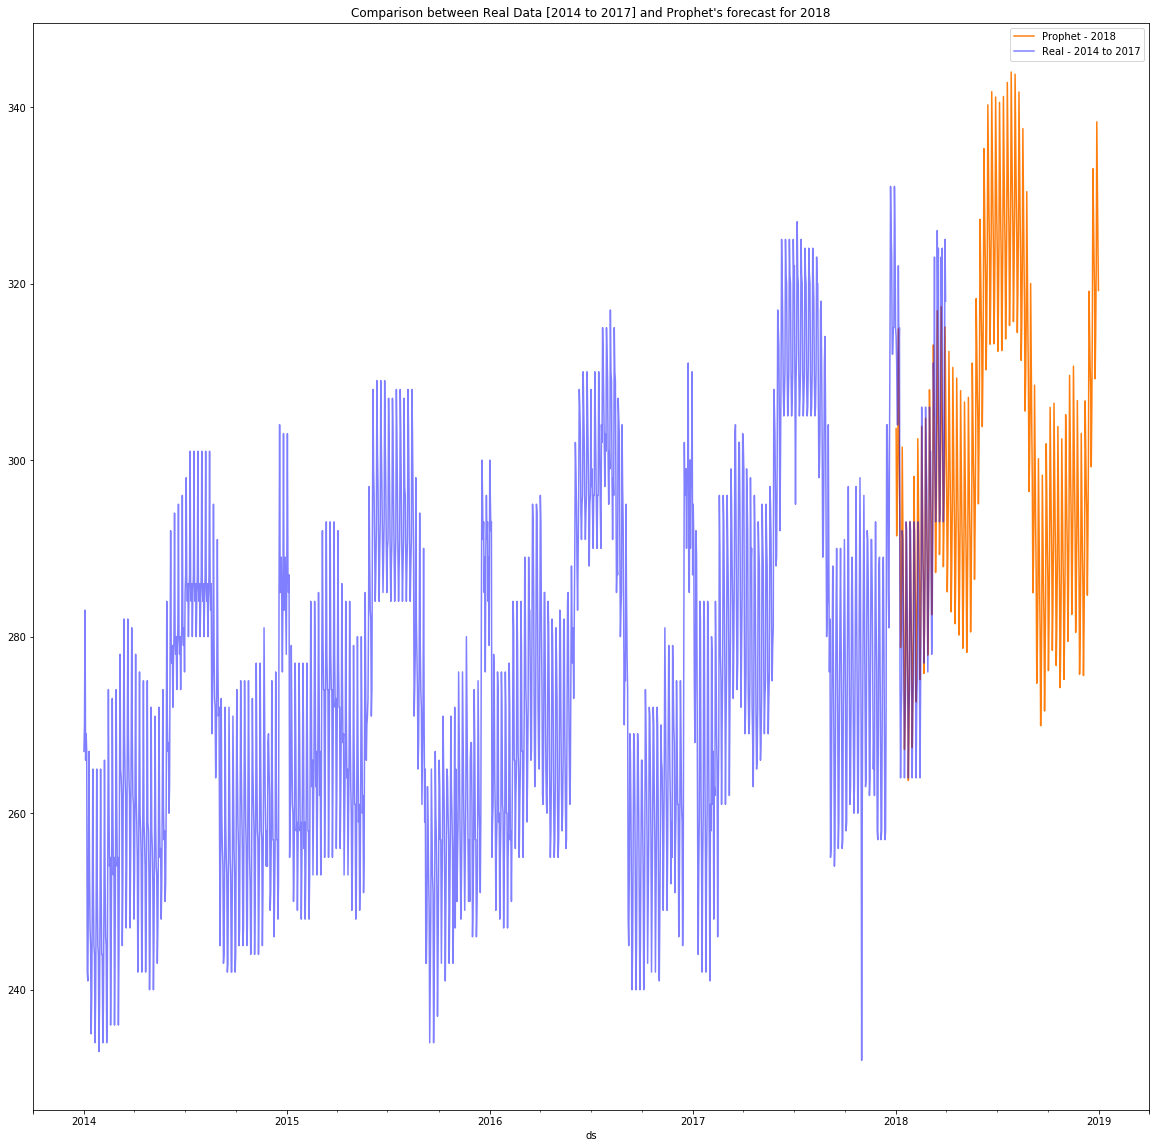

In [119]:
fig, ax = plt.subplots(figsize=(20,20))
forecast_2018.plot(x='ds', y='yhat', ax=ax, label='Prophet - 2018', color='C1')
daily_data.plot(x='ds', y='y', ax=ax, label='Real - 2014 to 2017', color='b', alpha=0.5)

plt.legend()
plt.title("Comparison between Real Data [2014 to 2017] and Prophet's forecast for 2018")
plt.show()

### 2) Exponential Smoothing

In [148]:
n = 90
model = ExponentialSmoothing(train['y'] ,seasonal_periods=365 ,trend=None, seasonal='add').fit()
holt = model.forecast(n)

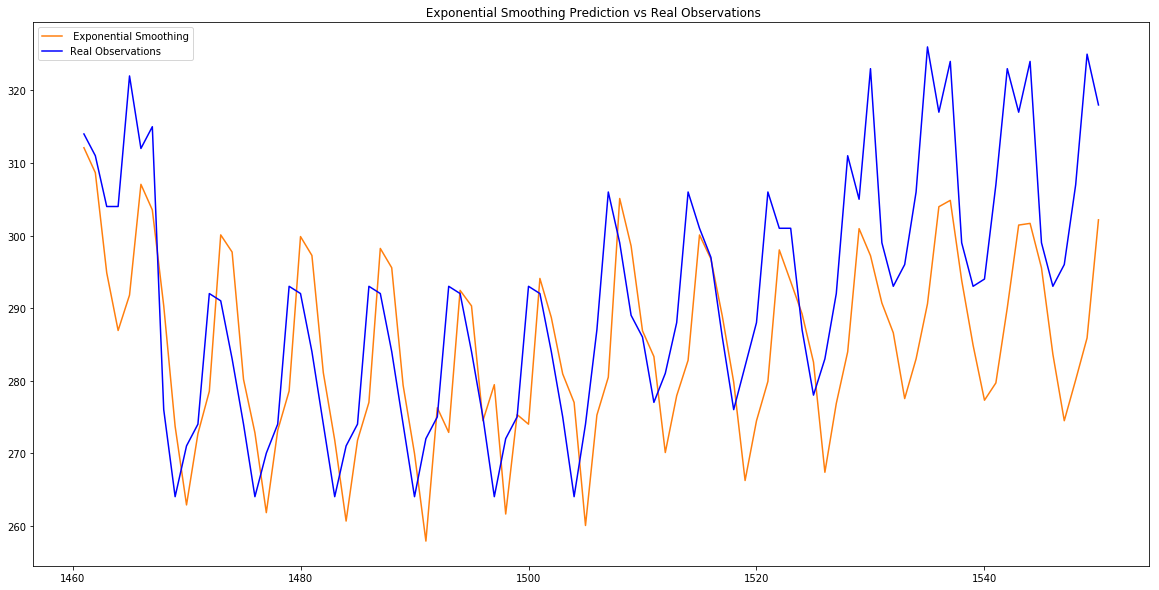

Mean Absolute Error: 11.6449747041
Root Mean Square Error : 14.545007473573529


In [149]:
fig = plt.figure(figsize=(20,10))
plt.plot(holt, label=' Exponential Smoothing', color='C1')
plt.plot(test.iloc[:n,1], label='Real Observations', color='b')
plt.title(' Exponential Smoothing Prediction vs Real Observations')
plt.legend()
plt.show()
print('Mean Absolute Error: ' + str(mean_absolute_error(y_true=test.y, y_pred=holt)))
print('Root Mean Square Error : ' + str(sqrt(mean_squared_error(y_true=test.y, y_pred=holt))))

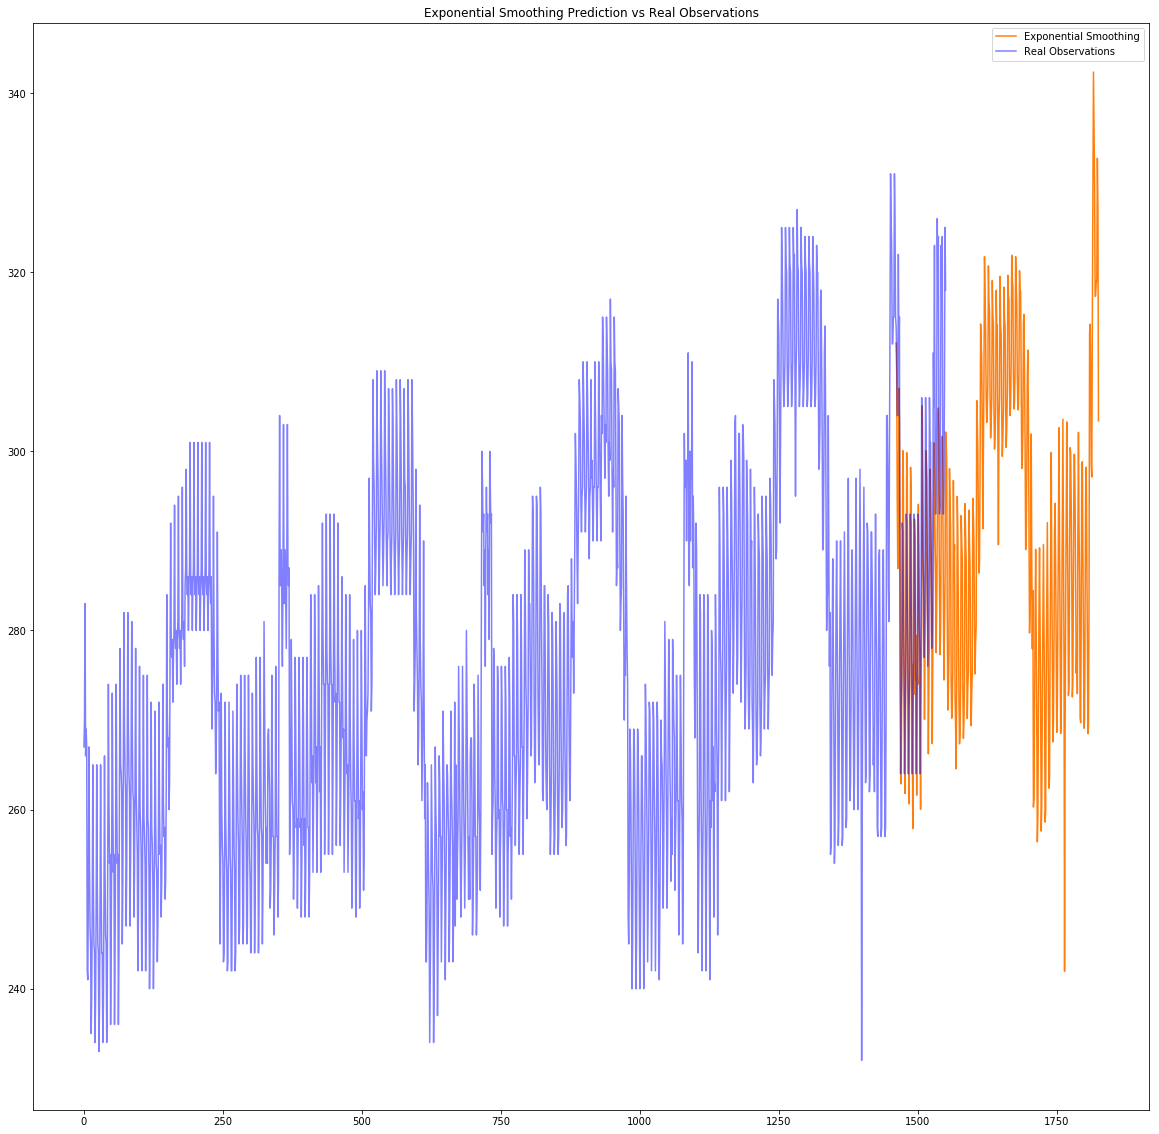

In [150]:
holt = model.forecast(365)
fig = plt.figure(figsize=(20,20))
plt.plot(holt, label='Exponential Smoothing', color='C1')
plt.plot(daily_data.y, label='Real Observations', color='b', alpha=0.5)
plt.title('Exponential Smoothing Prediction vs Real Observations')
plt.legend()
plt.show()

## Conclusion

Prophet is at the same time easier to use and better at forecasting than statsmodels' ExponentialSmoothing. The latter seems to be pickup up on outliers, such as that quick swing at around 1750 on the last graph, while Prophet has really understood the movement and seasonality of the time series without any efforts.